In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
from tqdm import tqdm
import seaborn as sns
from tsfresh import extract_features
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction.settings import EfficientFCParameters, ComprehensiveFCParameters
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV


plt.rcParams['figure.figsize'] = (12, 8)

## <font color=orange>  Helper Functions </font>

In [2]:
# Constants
THRESHOLD_SPRINGBACK = 0.5 # in degrees/section_dim 

def calculateBendingAngleAfterSpringback(df,
                                         threshold   = 1.0,
                                         section_dim = 200,
                                         median      = True):

      """Iterates backwards through dataframe in section_dim rows sections and 
      calculates the difference between the first and the last bending angle of 
      the section. If the difference is greater than threshold, the section is 
      considered as out of final beding angle range and the bending angle after 
      springback is calculated as the median of the after springback range.
      param: 
            df          : DataFrame
            threshold   : increasing rate of bedning angle in degrees/section_dim
            section_dim : section dimension to be considered while iterating.
            median      : True to use a median function on the section, that 
                        is considered as part of springback range.
      return: bending angle after springback
      """
      # drop the rows where at least one element is missing
      df.dropna(inplace=True)
      row = len(df) - 1
      while row > 0:
            if abs(df['Bending_Angle'].iloc[row] - df['Bending_Angle'].iloc[row - section_dim]) > threshold:
                  break
            row -= section_dim
      df_springback = df.iloc[row:]
      if median:
            return df_springback['Bending_Angle'].median()
      else:
            return df_springback['Bending_Angle'].mean()

def extractWorkpieceData(file_path, training_data = True):

      """Extracts data from all csv files in a folder and returns a dataframe 
      param:
            file_path : path to the folder containing the csv files
      return:
            df        : dataframe with the columns: Aluminum, Max_Bending_Angle, 
                        Thickness and Springback.
      """
      
      if training_data:
            position_max_bending_angle = 2
      else:
            position_max_bending_angle = 3

      # new dataframe
      df_workpiece = pd.DataFrame(columns=['Aluminum','Max_bending_angle', 'Thickness','Springback'])
      springback = []
      material = []
      thickness = []
      max_bending_angle = []

      # extract data from csv files
      files = os.listdir(file_path)
      files = [f for f in files if f.endswith('.csv')]
      for file in tqdm(files):
            df_temp = pd.read_csv(file_path + str(file), sep=';', decimal=',')
            # extract material from file name
            material_value = int(file.split('_')[0])
            material.append(material_value)
            # extract thickness from file name
            thickness_value = int(file.split('_')[1]) / 10
            thickness.append(thickness_value)
            # extract max bending angle from file name
            max_bending_angle.append(int(file.split('_')[position_max_bending_angle]))
            # calculate springback
            max_bending_angle_value = df_temp['Bending_Angle'].max()
            bending_angle_after_springback = calculateBendingAngleAfterSpringback(df_temp, threshold=THRESHOLD_SPRINGBACK, section_dim=200, median=True)
            springback_value = max_bending_angle_value - bending_angle_after_springback
            springback.append(springback_value)
      # add the values from the lists to dataframe
      df_workpiece['Thickness'] = thickness
      df_workpiece['Springback'] = springback
      df_workpiece['Max_bending_angle'] = max_bending_angle
      # material column is categorical and in order to avoid spurious correlation 
      # between features and prediction due to numerical values, it must be binary
      df_workpiece['Aluminum'] = [1 if x == 1 else 0 for x in material]
      return df_workpiece

def extractForceData(file_path, low_pass_filter=False, only_elastic_deformation=False):
      
      """Extracts Force1, Force2, Force3 and Time from every csv file and merges 
      them into one dataframe. Additionaly, each sample is assigned a unique id 
      that corresponds to the index in the workpiece dataframe.
      param:
            file_path : path to the folder containing the csv files
      return:
            df        : dataframe
      """

      #  all force dataframes into one dataframe for tsfresh
      files = os.listdir(file_path)
      files = [f for f in files if f.endswith('.csv')]
      df_forces = pd.DataFrame(columns=['id','Time','Force1','Force2','Force3'])
      id_ = 0
      for file in tqdm(files):
            df_temp = pd.read_csv(file_path + str(file), sep=';', decimal=',')
            df_temp['Time'] = pd.to_datetime(df_temp['Time'])
            df_temp['id'] = id_
            if low_pass_filter:
                  # low pass filter on force columns
                  window_length = 30
                  poly_order = 3
                  Force1 = df_temp['Force1'].tolist()
                  Force2 = df_temp['Force2'].tolist()
                  Force3 = df_temp['Force3'].tolist()
                  Force1_hat = scipy.signal.savgol_filter(Force1, window_length=window_length, polyorder=poly_order)
                  Force2_hat = scipy.signal.savgol_filter(Force2, window_length=window_length, polyorder=poly_order)
                  Force3_hat = scipy.signal.savgol_filter(Force3, window_length=window_length, polyorder=poly_order)
                  df_temp['Force1'] = Force1_hat
                  df_temp['Force2'] = Force2_hat
                  df_temp['Force3'] = Force3_hat
            if only_elastic_deformation:
                  df_temp = df_temp.iloc[:1000, :]
            df_forces = pd.concat([df_forces, df_temp[['id','Time','Force1','Force2','Force3']]], ignore_index=True)
            id_ += 1
      # change data type of columns
      df_forces['id'] = df_forces['id'].astype(int)
      df_forces['Force1'] = df_forces['Force1'].astype(float)
      df_forces['Force2'] = df_forces['Force2'].astype(float)
      df_forces['Force3'] = df_forces['Force3'].astype(float)
      return df_forces

## <font color=orange>  1. Data aquisition </font>

In [3]:
training_workpiece_path = "1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/"
test_workpiece_path = "1_Datensatz_Halbzeug_Blechdicke/Testdaten/Messdaten gesamt/"
df_workpiece_training = extractWorkpieceData(training_workpiece_path, training_data=True)
df_workpiece_test = extractWorkpieceData(test_workpiece_path, training_data=False)

100%|██████████| 144/144 [00:14<00:00, 10.22it/s]


In [4]:
trainig_forces_path = '1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten ML/'
test_forces_path = '1_Datensatz_Halbzeug_Blechdicke/Testdaten/Messdaten ML/'
df_forces_training = extractForceData(trainig_forces_path, low_pass_filter=True, only_elastic_deformation=True)
df_forces_test = extractForceData(test_forces_path, low_pass_filter=True, only_elastic_deformation=True)

100%|██████████| 144/144 [00:36<00:00,  3.90it/s]


## <font color=orange>  2. Data understaning </font>

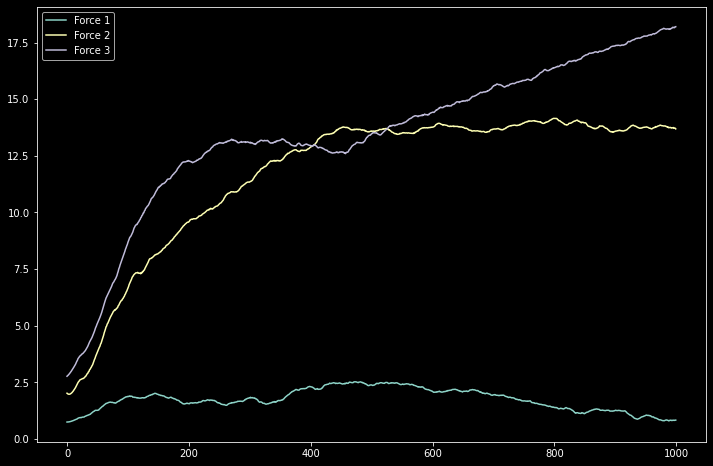

In [6]:
# print force curves
plt.plot(df_forces_training[df_forces_training['id'] == 0]['Force1'], label ='Force 1')
plt.plot(df_forces_training[df_forces_training['id'] == 0]['Force2'], label ='Force 2')
plt.plot(df_forces_training[df_forces_training['id'] == 0]['Force3'], label ='Force 3')
plt.legend()
plt.show()

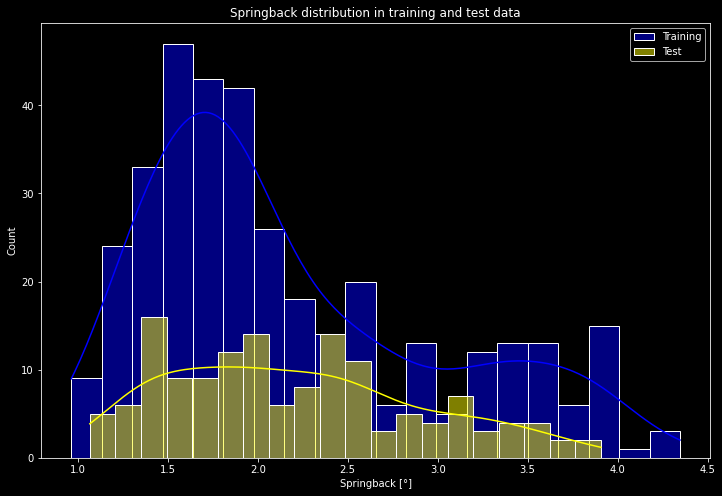

In [6]:
# Distribution of springback values
sns.histplot(df_workpiece_training['Springback'], kde=True, bins=20, label='Training', color='blue')
sns.histplot(df_workpiece_test['Springback'], kde=True, bins=20, label='Test', color='yellow')
plt.xlabel('Springback [°]')
plt.title('Springback distribution in training and test data')
plt.legend()
plt.show()

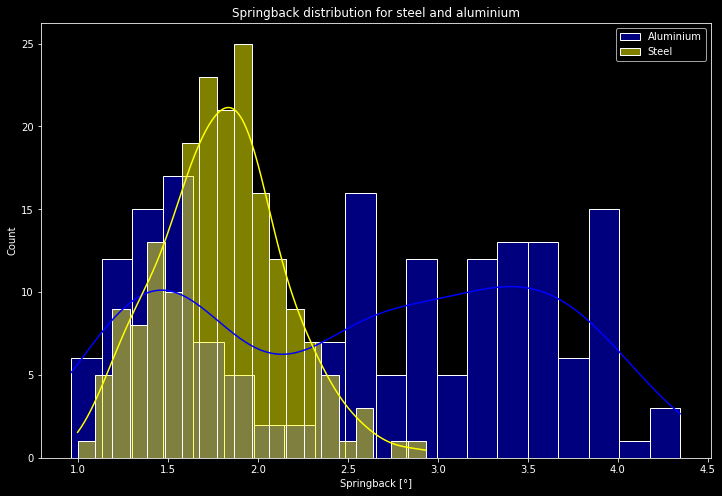

In [7]:
# Distribution of springback values aluminium vs steel
sns.histplot(df_workpiece_training[df_workpiece_training['Aluminum'] == 1]['Springback'], kde=True, bins=20, label='Aluminium', color='blue')
sns.histplot(df_workpiece_training[df_workpiece_training['Aluminum'] == 0]['Springback'], kde=True, bins=20, label='Steel', color='yellow')
plt.xlabel('Springback [°]')
plt.title('Springback distribution for steel and aluminium')
plt.legend()
plt.show()

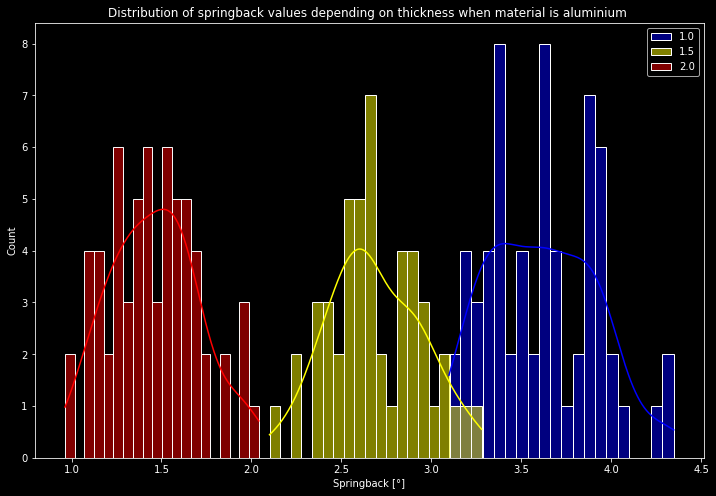

In [8]:
# Distribution of springback values depending on thickness if material is aluminium
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 1) & (df_workpiece_training['Thickness'] == 1.0)]['Springback'], kde=True, bins=20, label='1.0', color='blue')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 1) & (df_workpiece_training['Thickness'] == 1.5)]['Springback'], kde=True, bins=20, label='1.5', color='yellow')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 1) & (df_workpiece_training['Thickness'] == 2.0)]['Springback'], kde=True, bins=20, label='2.0', color='red')
plt.xlabel('Springback [°]')
plt.title('Distribution of springback values depending on thickness when material is aluminium ')
plt.legend()
plt.show()

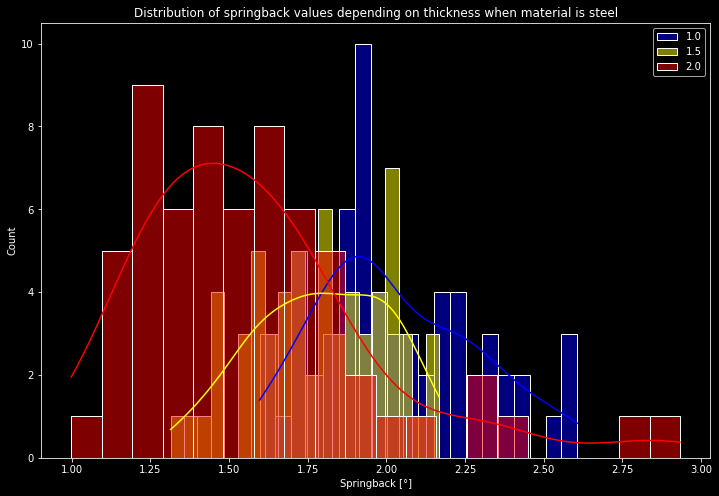

In [9]:
# Distribution of springback values depending on thickness if material is steel
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Thickness'] == 1.0)]['Springback'], kde=True, bins=20, label='1.0', color='blue')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Thickness'] == 1.5)]['Springback'], kde=True, bins=20, label='1.5', color='yellow')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Thickness'] == 2.0)]['Springback'], kde=True, bins=20, label='2.0', color='red')
plt.xlabel('Springback [°]')
plt.title('Distribution of springback values depending on thickness when material is steel')
plt.legend()
plt.show()

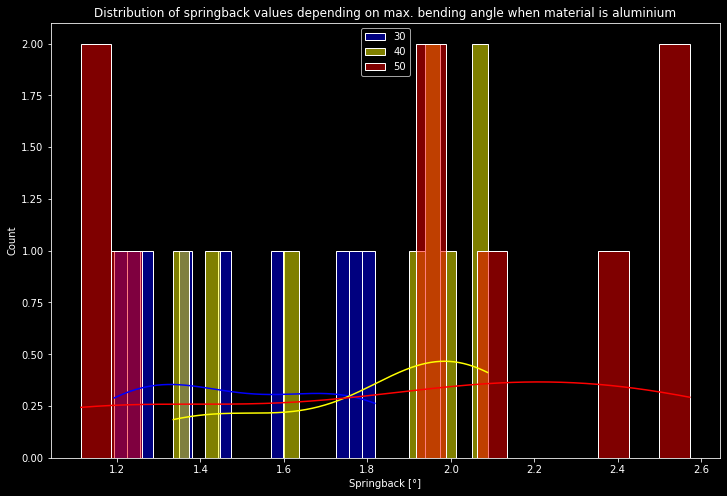

In [10]:
# Distribution of springback values depending on max. bending angle for aluminium
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Max_bending_angle'] == 30)]['Springback'], kde=True, bins=20, label='30', color='blue')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Max_bending_angle'] == 40)]['Springback'], kde=True, bins=20, label='40', color='yellow')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Max_bending_angle'] == 50)]['Springback'], kde=True, bins=20, label='50', color='red')
plt.xlabel('Springback [°]')
plt.title('Distribution of springback values depending on max. bending angle when material is aluminium')
plt.legend()
plt.show()

## <font color=orange>  3. Data preprocessing </font>

In [7]:
THRESHOLD_STRONG_CORRELATION = 0.7
THRESHOLD_MODERATE_CORRELATION = 0.5
THRESHOLD_WEAK_CORRELATION = 0.33

### <font color=orange>  3.1. Linear Correlation - Pearson </font>

In [8]:
# features extraction with tsfresh from those three different force curves.


training_features_tsfresh = extract_relevant_features(df_forces_training, 
                                                      df_workpiece_training['Springback'],
                                                      column_id='id', 
                                                      column_sort='Time',
                                                      default_fc_parameters=EfficientFCParameters(),
                                                      n_jobs=4)


#training_features_tsfresh = pd.read_csv('training_features_tsfresh.csv')

Feature Extraction: 100%|██████████| 20/20 [02:40<00:00,  8.04s/it]


In [9]:
# discard the pair-wise highly correlated features (linearly dependent, redundant features)
print("Number of selected features from tsfresh : " + str(training_features_tsfresh.shape[1]))
corr_matrix = training_features_tsfresh.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
training_features_tsfresh=training_features_tsfresh.drop(training_features_tsfresh[to_drop], axis=1)
print("Number of selected features after removing redundant features : " + str(training_features_tsfresh.shape[1]))

Number of selected features from tsfresh : 1794
Number of selected features after removing redundant features : 185


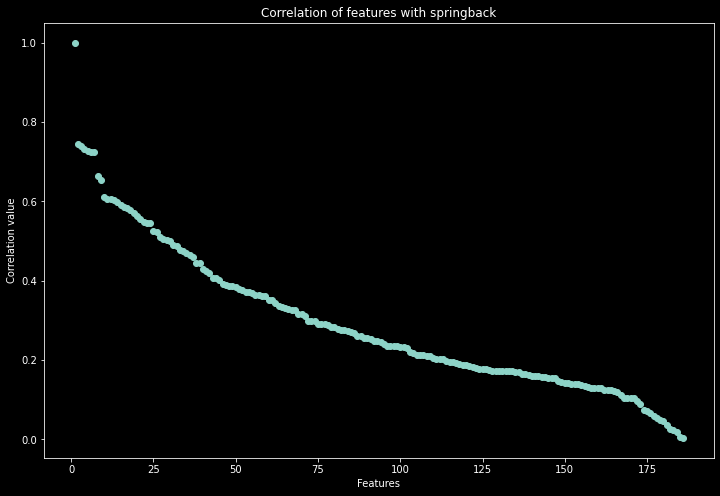

In [10]:
# Correlation of remaining features with springback
training_features_tsfresh["Springback"]=df_workpiece_training["Springback"].values
corr_values=abs(training_features_tsfresh.corrwith(training_features_tsfresh["Springback"])).sort_values(ascending=False)
plt.scatter(np.linspace(1,len(corr_values),len(corr_values)),corr_values)
plt.title("Correlation of features with springback")
plt.xlabel("Features")
plt.ylabel("Correlation value")
plt.show()

In [11]:
# delete Springback column from training_features_tsfresh
training_features_tsfresh.drop(columns=['Springback'], inplace=True)
# join df_workpiece_training and training_features_tsfresh
df_train = training_features_tsfresh.join(df_workpiece_training, how='inner')

In [12]:
df_train

,Force1__standard_deviation,Force2__minimum,Force1__cid_ce__normalize_True,Force1__longest_strike_below_mean,"Force2__fft_coefficient__attr_""real""__coeff_7",Force3__max_langevin_fixed_point__m_3__r_30,Force1__max_langevin_fixed_point__m_3__r_30,Force1__variance_larger_than_standard_deviation,Force3__ar_coefficient__coeff_0__k_10,"Force3__matrix_profile__feature_""median""__threshold_0.98",...,Force3__number_cwt_peaks__n_1,"Force1__fft_coefficient__attr_""real""__coeff_20",Force1__partial_autocorrelation__lag_7,Force3__count_below_mean,Force1__energy_ratio_by_chunks__num_segments_10__segment_focus_3,Force1__partial_autocorrelation__lag_8,Aluminum,Max_bending_angle,Thickness,Springback
0,0.481011,1.971040,0.925050,260.0,-44.161099,15.394744,2.252031,0.0,0.013249,10.173185,...,72.0,-3.244089,-0.025681,502.0,0.108684,-0.032352,1,30,1.0,3.363434
1,0.994395,1.459960,0.518029,350.0,-31.485357,16.522356,4.838764,0.0,0.018300,13.286466,...,71.0,1.168726,-0.003423,428.0,0.095867,-0.006877,1,30,1.0,3.305664
2,0.843222,2.940276,0.599184,336.0,-13.083821,15.237223,4.256042,0.0,0.018481,16.927290,...,78.0,3.618654,-0.021515,513.0,0.164226,-0.012856,1,30,1.0,3.207978
3,0.752030,2.154232,0.733441,362.0,-39.736552,13.097553,3.481423,0.0,0.018452,13.296473,...,74.0,0.999449,-0.004582,542.0,0.097447,-0.017971,1,31,1.0,3.411530
4,0.608260,1.921805,0.875325,323.0,-36.882380,13.267013,2.404597,0.0,0.014020,7.763718,...,79.0,-10.856684,-0.001338,521.0,0.098342,-0.009479,1,31,1.0,3.379150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,3.324155,6.721479,0.454775,511.0,-41.864060,77.975805,36.198003,1.0,0.064407,1.237965,...,72.0,-8.796112,-0.016792,373.0,0.130110,-0.014804,0,49,2.0,1.536682
359,3.963323,8.197593,0.434668,510.0,-97.744691,80.323410,17.830446,1.0,0.060205,1.061766,...,75.0,-19.242231,-0.018410,381.0,0.142061,-0.018173,0,49,2.0,1.892334
360,5.546466,15.766999,0.302465,517.0,-148.617753,111.278113,26.157976,1.0,0.045949,3.502109,...,69.0,-4.105312,-0.056992,401.0,0.130095,-0.050029,0,50,2.0,1.146362
361,5.285940,11.029195,0.349486,494.0,-110.003471,99.997221,29.423949,1.0,0.049206,1.163017,...,76.0,-20.630310,-0.013188,388.0,0.128853,-0.015405,0,50,2.0,1.199310


In [13]:
# select only features that have at least a weak correlation with springback,
# because machine learning algorithms are very good at selecting features
corr_values=abs(df_train.corrwith(df_train["Springback"]))
to_keep = [column for column in corr_values.index if corr_values[column] > 0.33]
df_train=df_train[to_keep]
print("Number of selected features after removing very weak correlated features : " + str(df_train.shape[1]))

Number of selected features after removing very weak correlated features : 67


In [14]:
df_train

,Force1__standard_deviation,Force2__minimum,Force1__cid_ce__normalize_True,Force1__longest_strike_below_mean,"Force2__fft_coefficient__attr_""real""__coeff_7",Force3__max_langevin_fixed_point__m_3__r_30,Force1__variance_larger_than_standard_deviation,Force3__ar_coefficient__coeff_0__k_10,"Force3__matrix_profile__feature_""median""__threshold_0.98","Force1__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""",...,"Force1__fft_coefficient__attr_""real""__coeff_15",Force3__fourier_entropy__bins_100,Force1__ar_coefficient__coeff_1__k_10,Force2__ratio_beyond_r_sigma__r_2,Force2__symmetry_looking__r_0.1,Force1__large_standard_deviation__r_0.25,Force3__count_below_mean,Aluminum,Thickness,Springback
0,0.481011,1.971040,0.925050,260.0,-44.161099,15.394744,0.0,0.013249,10.173185,-0.131307,...,-13.335170,0.136002,1.224749,0.072,0.0,1.0,502.0,1,1.0,3.363434
1,0.994395,1.459960,0.518029,350.0,-31.485357,16.522356,0.0,0.018300,13.286466,-0.183588,...,2.831764,0.136002,1.246426,0.063,1.0,0.0,428.0,1,1.0,3.305664
2,0.843222,2.940276,0.599184,336.0,-13.083821,15.237223,0.0,0.018481,16.927290,-0.186505,...,-5.429082,0.136002,1.296908,0.037,1.0,1.0,513.0,1,1.0,3.207978
3,0.752030,2.154232,0.733441,362.0,-39.736552,13.097553,0.0,0.018452,13.296473,-0.197851,...,2.072774,0.181214,1.387918,0.072,1.0,0.0,542.0,1,1.0,3.411530
4,0.608260,1.921805,0.875325,323.0,-36.882380,13.267013,0.0,0.014020,7.763718,-0.222552,...,5.350161,0.136002,1.394952,0.078,1.0,1.0,521.0,1,1.0,3.379150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,3.324155,6.721479,0.454775,511.0,-41.864060,77.975805,1.0,0.064407,1.237965,-0.527067,...,-17.209485,0.136002,1.513874,0.073,1.0,0.0,373.0,0,2.0,1.536682
359,3.963323,8.197593,0.434668,510.0,-97.744691,80.323410,1.0,0.060205,1.061766,-0.515377,...,-9.580147,0.125256,1.599306,0.066,1.0,0.0,381.0,0,2.0,1.892334
360,5.546466,15.766999,0.302465,517.0,-148.617753,111.278113,1.0,0.045949,3.502109,-0.461363,...,-34.033845,0.136002,1.463549,0.059,1.0,1.0,401.0,0,2.0,1.146362
361,5.285940,11.029195,0.349486,494.0,-110.003471,99.997221,1.0,0.049206,1.163017,-0.500185,...,-6.167840,0.136002,1.555579,0.061,1.0,1.0,388.0,0,2.0,1.199310


In [15]:
corr_values=abs(df_train.corrwith(df_train["Springback"]))
to_keep = [column for column in corr_values.index if corr_values[column] > 0.6]
df_train_high=df_train[to_keep]
print("Number of selected features after removing weak correlated features : " + str(df_train_high.shape[1]))

Number of selected features after removing weak correlated features : 14


In [24]:
# length for plot
len(df_train_high.iloc[:,:-1].columns)

6

c:\Users\rares\anaconda3\envs\tutorium\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


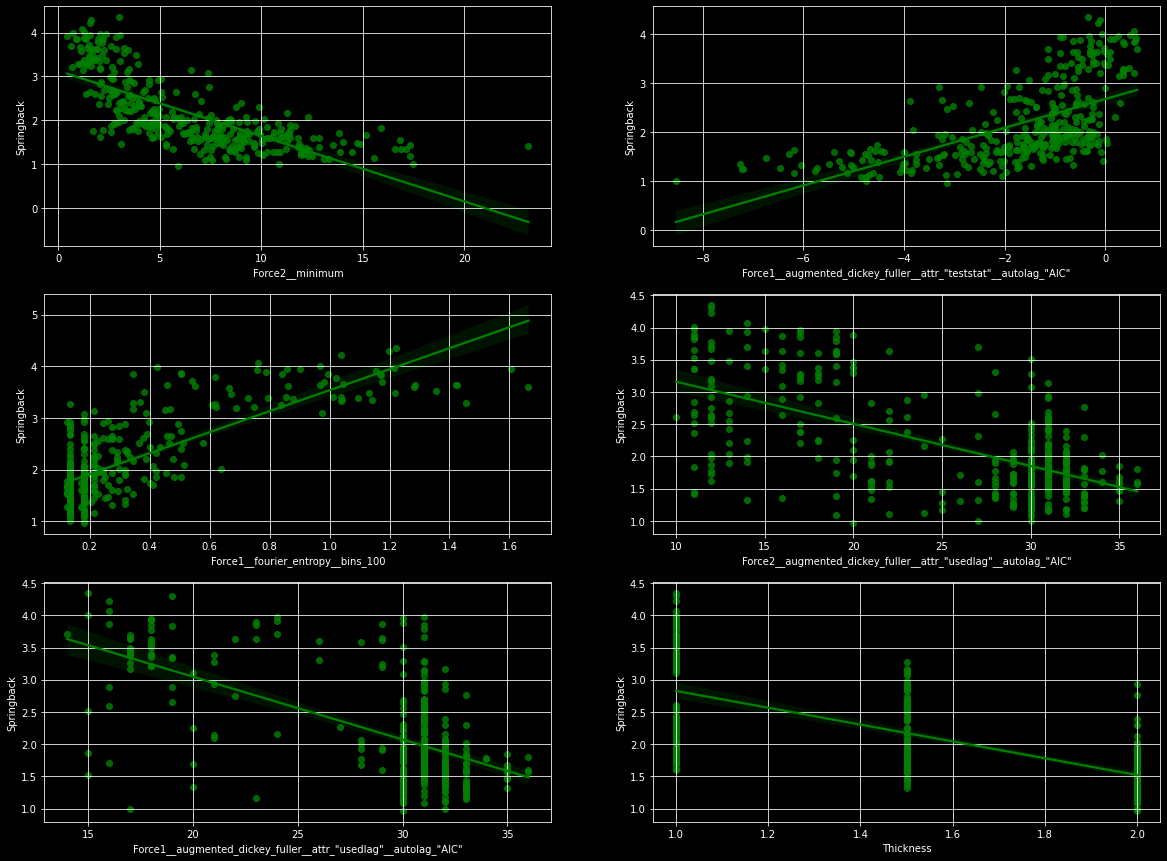

In [26]:
number_ = int(len(df_train_high.iloc[:,:-1].columns)/2)
fig, ax1 = plt.subplots(number_,2, figsize=(20,15))
k = 0
columns = df_train_high.iloc[:,:-1].columns
for i in range(number_):
    for j in range(2):
            sns.regplot(df_train_high[columns[k]],df_train_high["Springback"],ax=ax1[i][j],color="green")
            ax1[i][j].grid(True)
            k += 1
plt.show()

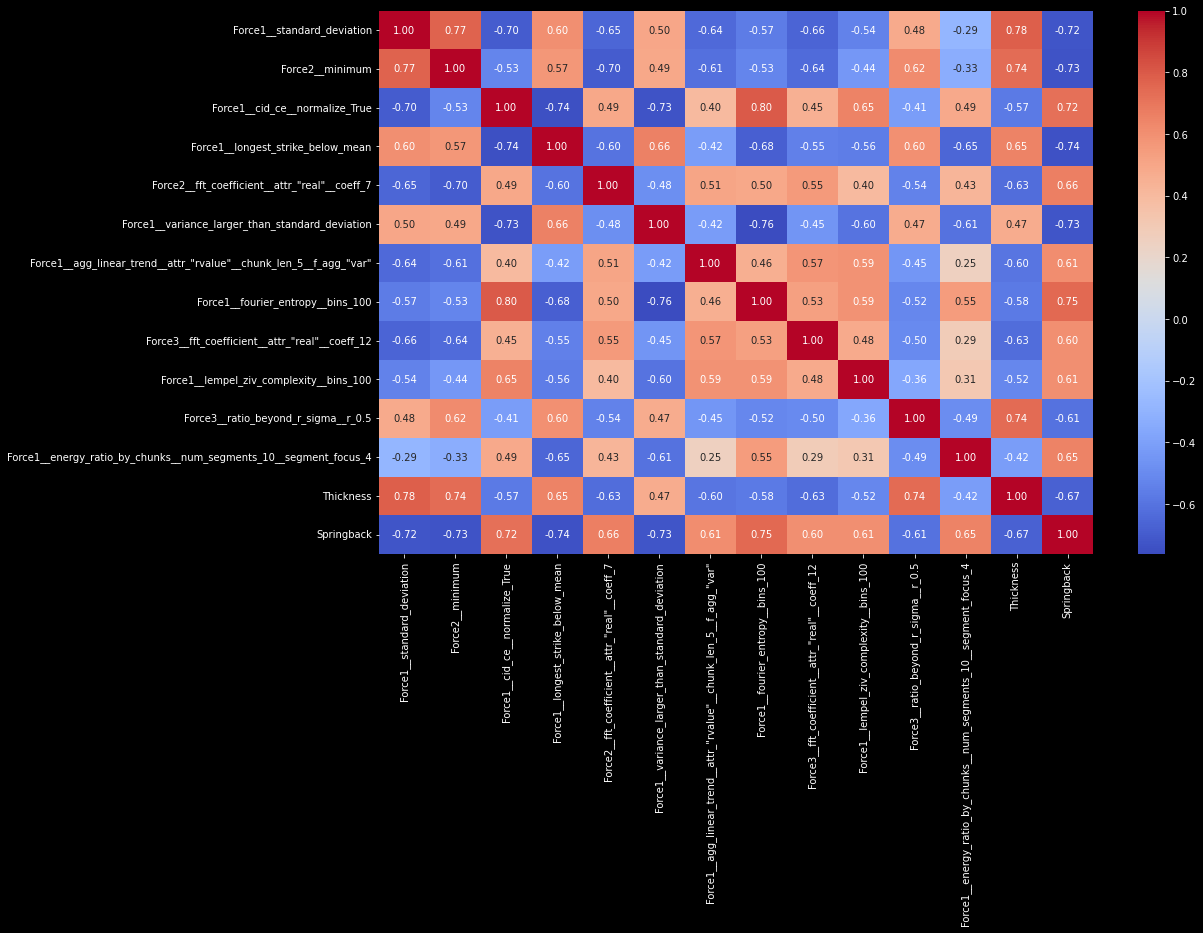

In [16]:
plt.figure(figsize = (16, 10))
sns.heatmap(df_train_high.corr(), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

### <font color=orange>  3.2. Wrapper </font>

In [ ]:
# features extraction with tsfresh from those three different force curves.

"""
training_features_tsfresh = extract_features(df_forces_training, 
                                                      
                                                      column_id='id', 
                                                      column_sort='Time',
                                                      default_fc_parameters=EfficientFCParameters(),
                                                      n_jobs=4)
"""

#training_features_tsfresh = pd.read_csv('tsfresh_features_unfiltered.csv')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
# discard the pair-wise highly correlated features (linearly dependent, redundant features)
print("Number of selected features from tsfresh : " + str(training_features_tsfresh.shape[1]))
corr_matrix = training_features_tsfresh.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
training_features_tsfresh=training_features_tsfresh.drop(training_features_tsfresh[to_drop], axis=1)
print("Number of selected features after removing redundant features : " + str(training_features_tsfresh.shape[1]))

In [ ]:
X_train_FS, X_test_FS, y_train_FS, y_test_FS = train_test_split(
    training_features_tsfresh,
    df_workpiece_training['Springback'],
    test_size=0.3,
    random_state=0)

In [ ]:
sfs = SFS(RandomForestRegressor(), 
           k_features=10, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=3)

sfs = sfs.fit(np.array(X_train_FS), y_train_FS)

In [ ]:
sfs.k_feature_idx_
X_train_FS.columns[list(sfs.k_feature_idx_)]

## <font color=orange>  4. Model Training </font>

In [23]:
#  extract all features from the test data

test_features_tsfresh = extract_features(df_forces_test,
                                         default_fc_parameters = EfficientFCParameters(),
                                         column_id='id', 
                                         column_sort='Time',
                                         n_jobs=4)

df_test_total = test_features_tsfresh.join(df_workpiece_test, how='inner')

#df_test_total = pd.read_csv('df_test.csv')

Feature Extraction:  25%|██▌       | 5/20 [00:33<01:38,  6.56s/it]

In [18]:
# select only the features used for training
features_training = list(df_train)
df_test = df_test_total[features_training]

In [19]:
df_test

,Force1__standard_deviation,Force2__minimum,Force1__cid_ce__normalize_True,Force1__longest_strike_below_mean,"Force2__fft_coefficient__attr_""real""__coeff_7",Force3__max_langevin_fixed_point__m_3__r_30,Force1__variance_larger_than_standard_deviation,Force3__ar_coefficient__coeff_0__k_10,"Force3__matrix_profile__feature_""median""__threshold_0.98","Force1__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""",...,"Force1__fft_coefficient__attr_""real""__coeff_15",Force3__fourier_entropy__bins_100,Force1__ar_coefficient__coeff_1__k_10,Force2__ratio_beyond_r_sigma__r_2,Force2__symmetry_looking__r_0.1,Force1__large_standard_deviation__r_0.25,Force3__count_below_mean,Aluminum,Thickness,Springback
0,3.490857,3.359562,3.560036,1929.0,-158.115333,33.566517,1.0,0.145729,1.761357,-0.243557,...,-62.484935,0.181214,0.269451,0.054360,1.0,1.0,1479.0,1,1.0,3.115600
1,3.660436,3.036162,3.307546,1921.0,-308.098244,34.253063,1.0,0.166693,1.765374,-0.195159,...,-3.665796,0.136002,0.268186,0.054084,1.0,1.0,1410.0,1,1.0,2.935669
2,3.745550,2.119853,3.156677,1999.0,-315.908215,34.278085,1.0,0.162492,1.784414,-0.226478,...,-94.649554,0.125256,0.303906,0.057818,1.0,1.0,1442.0,1,1.0,3.009246
3,3.108087,2.334055,4.037265,2274.0,-518.016705,26.980209,1.0,0.171631,1.756845,-0.126741,...,-16.023111,0.136002,0.201320,0.043407,1.0,1.0,1664.0,1,1.0,3.297333
4,3.082696,2.134561,4.080453,2276.0,-369.588542,27.064863,1.0,0.175644,1.736953,-0.154197,...,-99.951737,0.125256,0.226695,0.043754,1.0,1.0,1693.0,1,1.0,3.014801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,17.589459,14.789580,0.749269,2459.0,-1554.966615,160.735964,1.0,0.436405,119.733036,-0.235397,...,-611.494129,0.136002,0.595544,0.056959,1.0,1.0,1652.0,0,2.0,1.363617
140,19.619053,14.523382,0.681528,2523.0,-2232.944027,165.736378,1.0,0.456200,119.733036,-0.216662,...,-721.663670,0.125256,0.598326,0.054385,1.0,1.0,1644.0,0,2.0,1.446289
141,17.516707,11.081017,0.755751,2406.0,-2067.590766,164.331252,1.0,0.452077,118.016948,-0.225828,...,-797.367170,0.136002,0.605928,0.051134,1.0,1.0,1660.0,0,2.0,1.606506
142,17.439641,15.259309,0.767084,2535.0,-1942.604982,160.637360,1.0,0.451332,119.733036,-0.221821,...,-740.667817,0.136002,0.586749,0.055233,1.0,1.0,1695.0,0,2.0,1.799133


In [20]:
X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values
X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

In [20]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

sc_Xtrain = StandardScaler()
sc_Ytrain = StandardScaler()
X_train = sc_Xtrain.fit_transform(X_train)
y_train = sc_Ytrain.fit_transform(y_train)

y_train = y_train.reshape(len(y_train),)

In [22]:
rf = RandomForestRegressor( n_estimators = 10,
                            n_jobs = -1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

-0.23924337765759507

In [57]:
y_pred = sc_Ytrain.inverse_transform(rf.predict(sc_Xtrain.transform(X_test)).reshape(len(y_test), 1))

In [59]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

model = CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              }

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)

0:	learn: 0.9297905	total: 165ms	remaining: 16.4s
1:	learn: 0.8739289	total: 173ms	remaining: 8.48s
2:	learn: 0.8084570	total: 179ms	remaining: 5.77s
3:	learn: 0.7556186	total: 186ms	remaining: 4.45s
4:	learn: 0.7054689	total: 192ms	remaining: 3.65s
5:	learn: 0.6733570	total: 198ms	remaining: 3.1s
6:	learn: 0.6383758	total: 206ms	remaining: 2.73s
7:	learn: 0.6021247	total: 211ms	remaining: 2.43s
8:	learn: 0.5692698	total: 217ms	remaining: 2.19s
9:	learn: 0.5391911	total: 224ms	remaining: 2.01s
10:	learn: 0.5101389	total: 229ms	remaining: 1.85s
11:	learn: 0.4874128	total: 237ms	remaining: 1.74s
12:	learn: 0.4700391	total: 244ms	remaining: 1.63s
13:	learn: 0.4475578	total: 250ms	remaining: 1.54s
14:	learn: 0.4296848	total: 256ms	remaining: 1.45s
15:	learn: 0.4146829	total: 264ms	remaining: 1.39s
16:	learn: 0.3975304	total: 271ms	remaining: 1.32s
17:	learn: 0.3867415	total: 277ms	remaining: 1.26s
18:	learn: 0.3753536	total: 284ms	remaining: 1.21s
19:	learn: 0.3619609	total: 290ms	remainin

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002C65F8B1CA0>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [147]:
y_pred = grid.predict(X_test)

In [148]:
r2_score(y_test, y_pred)

0.6257502990653477

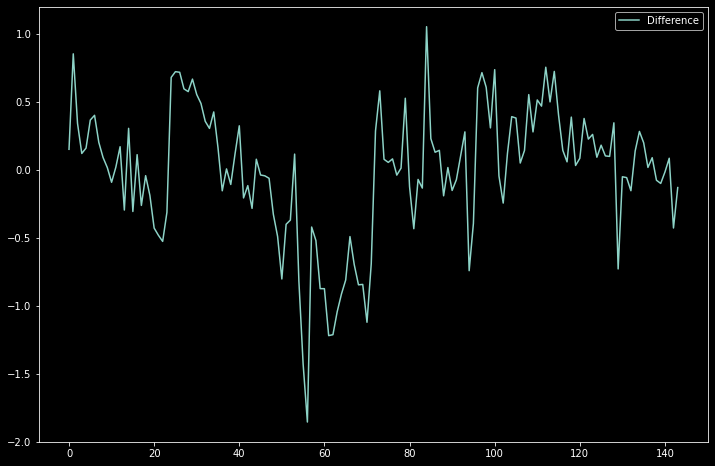

In [60]:
# difference over time
plt.plot(y_pred - y_test, label = 'Difference')
plt.legend()
plt.show()

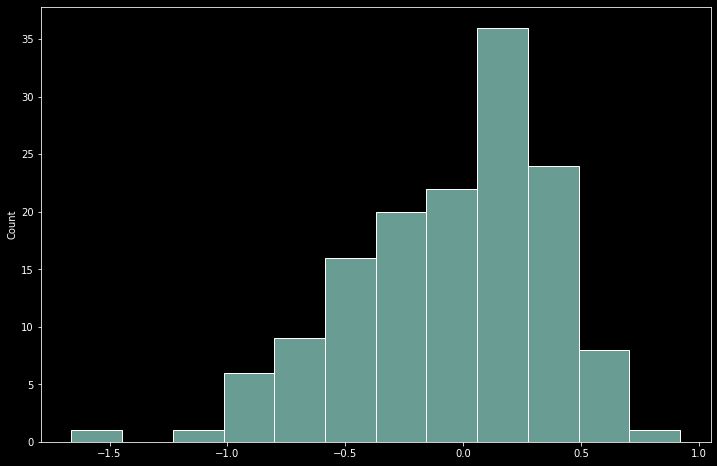

In [151]:
sns.histplot(y_pred - y_test, label = 'Difference')
plt.show()

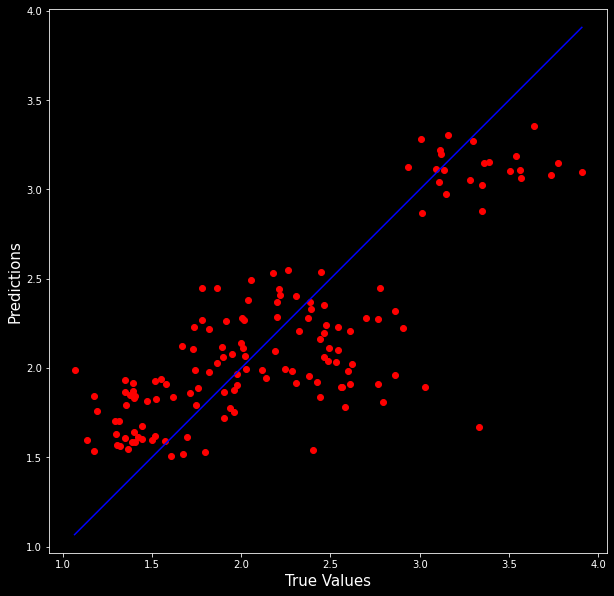

In [152]:
# preadictions over true values
plt.figure(figsize = (10,10))
plt.scatter(y_test, y_pred, c = 'red')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.axis('equal')
plt.show()

## <font color=orange>  Fragen </font>
* Biegewinkel am Ende oder Rückfederung?

## <font color=orange>  Morphological analysis </font>
<table>
  <tr>
    <th>X</th>
    <th>Alternative solution 1</th>
    <th>Alternative solution 2</th>
    <th>Alternative solution 3</th>
  </tr>
  <tr>
    <td>Material variation</td>
    <td>Aluminium and steel together</td>
    <td>Aluminium and steel separately</td>
  </tr>
  <tr>
    <td>Target/Prediction</td>
    <td>Springback</td>
    <td>Bending angle after springback</td>
  </tr>
    <tr>
    <td>Model</td>
    <td>NN Tensorflow</td>
    <td>Random Forest</td>
    <td>Booster</td>
  </tr>
</table>

## <font color=orange>  Infos </font>
* Feature selection: features that are pair-wise strongly correlated may lead to inprecise regression coefficients  https://www.westga.edu/academics/research/vrc/assets/docs/scatterplots_and_correlation_notes.pdf